### Quantum Linear regression

In [80]:
from qiskit import *
from  qiskit.extensions import *
import numpy as np
from qiskit.circuit.library import *
from qiskit.visualization import *
from qiskit.quantum_info import Statevector
from qiskit.circuit.library.standard_gates import RYGate

A = [[1,-1/3],[-1/3, 1]]

B = [0,1]

BNorm = B / np.linalg.norm(B)

NL = 2
NB = int(np.ceil(np.log2(len(B))))
             
breg = QuantumRegister(NB, name="B")
lreg = QuantumRegister(NL)
creg = ClassicalRegister(NL)
areg = QuantumRegister(1, name="anc")

QC = QuantumCircuit(areg, creg, lreg, breg)
QC.initialize(BNorm, breg)
QC.draw()


anc: ───────────────────
                           
q621_0: ───────────────────
                           
q621_1: ───────────────────
        ┌─────────────────┐
     B: ┤ Initialize(0,1) ├
        └─────────────────┘
 c10: 2/═══════════════════

In [81]:
S = Statevector(QC)
S.draw(output="Latex")

<IPython.core.display.Latex object>

In [82]:

U = HamiltonianGate(A, time=3*np.pi/4)
PE = PhaseEstimation(NL, U, QFT(NL, inverse=True, do_swaps=True), name="QPE").decompose()
R = list(range(1,NL+1))[::-1]+list(range(NL+1, NL+NB+1))
R

[2, 1, 3]

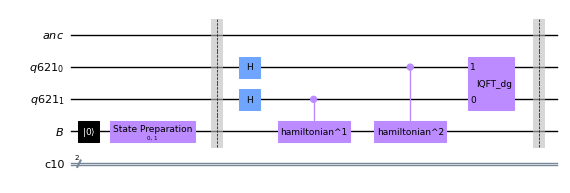

In [83]:

QC.barrier()
QC.append(PE,R)
QC.barrier()

QC = QC.decompose()
QC.draw(output="mpl", scale=0.5)


In [84]:
S = Statevector(QC)
S.draw(output="Latex")


<IPython.core.display.Latex object>

In [85]:
from qiskit.primitives import Sampler 

def binaryToPhase(binary):
    binary=list(binary[::-1])
    length = len(binary)
    res=0
    
    for i in range(length):
        digit=int(binary.pop())
        if digit==1:
            res=res+pow(2,i)  
    return res

QC.measure(1,0)
QC.measure(2,1)

job = Sampler().run(QC, shots=100)
for k,v in job.result().quasi_dists[0].items():
    print (bin(k)[2:], v, binaryToPhase(bin(k)[2:]))

1 0.56 1
11 0.44 3


In [86]:
C = 1/6
U = RYGate(2*np.arcsin(C/1)).control(NL)
QC.x(0)
QC.append(U, list(range(NL, -1, -1)))
QC.x(3)
QC.x(4)

QC.barrier()

U = RYGate(2*np.arcsin(C/5)).control(NL)
QC.x(2)
QC.x(4)
QC.append(U, list(range(NL, -1, -1)))
QC.x(2)
QC.x(4)

QC.append(QFT(NL, inverse=False), list(range(1,NL+1))[::-1])  
i = 8
j = 1
while i > 0:
    U = HamiltonianGate(A, time=-3*np.pi/4)
    g = QuantumCircuit(NB,name="H^"+str(i))

    for _ in range(i):
        g.append(U, list(range(NB)))
    
    g = g.to_gate().control(1)

    QC.append(g, [j]+list(range(NL+1, NL+NB+1)))
    i //= 2
    j += 1
    
QC.barrier()
for i in range(NL):
    QC.h(i+1)

S = Statevector(QC)
S.draw(output="Latex")

CircuitError: 'Index 4 out of range for size 4.'

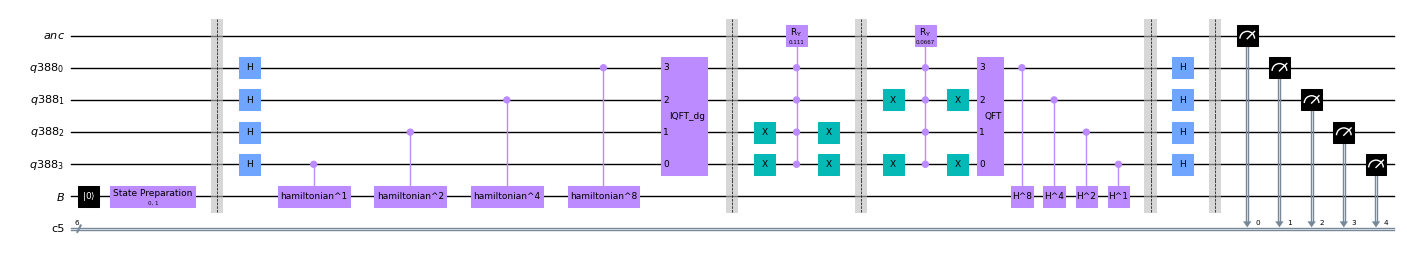

In [ ]:
QC.barrier()
for i in range(5):
    QC.measure(i,i)

QC.draw(output="mpl", scale=0.5, fold=1200)

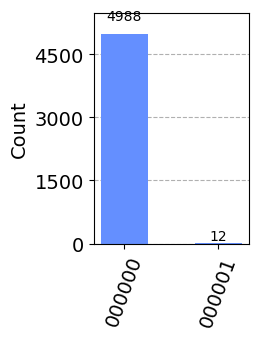

In [ ]:

backend = Aer.get_backend("aer_simulator")
job_sim = backend.run(transpile(QC, backend), shots=5000)

# Grab the results from the job.
result_sim = job_sim.result()
prob_1 = 0
ans = []
plot_histogram(result_sim.get_counts(), figsize=(2,3))

In [ ]:
nshots = 10000
amp_value = {}

for i in range(32,64):
    value = np.round(S[i-32], 10)
    if value:
        amp_value[bin(i)[3:]] = value

for k,v in result_sim.get_counts().items():
    if k[-1] == '1':
        ans.append(amp_value[k])

P1 = sum([i**2 for i in ans])*9

scaling = (C/np.sqrt(P1))
ans = [i/(scaling*np.linalg.norm(ans)) for i in ans]
print (scaling,)
print (ans, )
print (np.dot(ans, A))

KeyError: '000001'

In [87]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.x(qreg_q[0])
circuit.x(qreg_q[1])
circuit.barrier(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.z(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])

In [ ]:
job = Sampler().run(circuit, shots=1)
print (job.result())